## Sobre o trabalho

In [ ]:
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from utils import Utils

## Sobre os dados

Link:

A base de dados utilizada no processo de trinamento do modelo possui ~{quantidade_img} imagens porém parte dela 
já tinha passado pelo processo de data augmentation e algumas técnicas, como por exemplo, transformação da imagem colorida para preto e branco, pensamos que não faria sentido em relação a nossa problemática, pois consideramos que que as imagens de entrada do modelo seriam sempre tiradas com alguma exposição à luz.
Por isso, descartamos as imagens das frutas que continham essas imagens.


Para realizar o teste final do modelo utilizamos uma das frutas, no caso, a maçã que está disponível em outro dataset (Link_dataset).


Quantidade de dados:

1. Treinamento:

   - fresca: 3817
   - podre: 4545
   
   
2. Validação:

   - fresca: 1325
   - podre: 1056
  
  
3. Teste:

    - fresca: 200
    - podre 200

In [1]:
3817+4545+1325+1056

10743

Image shape: (192, 256, 3)


array([[[134, 109, 105],
        [134, 109, 105],
        [133, 108, 104],
        ...,
        [248, 248, 246],
        [251, 251, 249],
        [251, 251, 249]],

       [[128, 103,  99],
        [128, 103,  99],
        [127, 102,  98],
        ...,
        [252, 252, 250],
        [255, 255, 253],
        [255, 255, 253]],

       [[124,  99,  95],
        [124,  99,  95],
        [123,  98,  94],
        ...,
        [249, 249, 247],
        [252, 252, 250],
        [252, 252, 250]],

       ...,

       [[133, 134, 129],
        [132, 133, 128],
        [131, 132, 127],
        ...,
        [208, 208, 206],
        [211, 211, 209],
        [216, 216, 214]],

       [[134, 135, 130],
        [132, 133, 128],
        [131, 132, 127],
        ...,
        [213, 213, 211],
        [216, 216, 214],
        [221, 221, 219]],

       [[134, 135, 130],
        [132, 133, 128],
        [129, 130, 125],
        ...,
        [210, 210, 208],
        [211, 211, 209],
        [214, 214, 212]]

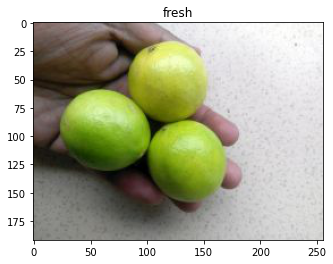

In [ ]:
Utils.view_random_img(target_dir="data/train", target_class="fresh")

In [ ]:
#Definição do caminho dos diretórios
train_dir = 'data/train/'
val_dir = 'data/validation/'

#Normalização das imagens, dividindo os valores dos pixels (0-255) por 255
#Passamos essa informação para Parametro rescale do ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255)
val_datagen = ImageDataGenerator(rescale=1/255)


#Carregamento das imagens e a divisão deles batches de tamanho 32, redimencionamento das imagens 
#para facilitar o treinamento para (224,224,3) e a própria biblioteca, devido a organização dos diretórios
#também consegue categorizar nossos dados. No nosso caso teremos duas categorias: Fresca ou Podre
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                              target_size=(224, 224),
                                              class_mode='binary', #Type of problem we are working with. Cuold be categorical
                                              batch_size=32)

val_data = val_datagen.flow_from_directory(directory=val_dir,
                                              target_size=(224, 224),
                                              class_mode='binary',
                                              batch_size=32)

#Pegando um lote de imagens/target no nosso dataset de treinamento
images, labels = train_data.next() 
print(f'{len(images)}, {len(labels)}')

#Pegando um lote de imagens/target no nosso dataset de validação
val_images, val_labels = val_data.next() 
print(f'{len(images)}, {len(labels)}')

#Visualizando a quantidade de lotes
print(f'Tamanho do lote: {len(train_data)}')

Found 8362 images belonging to 2 classes.
Found 2381 images belonging to 2 classes.
32, 32
32, 32
Tamanho do lote: 262


A célula acima foi utilizada para carregar as imagens, distribuir em lotes, realizar a normalização e redimencionamento das imagens utilizando a biblioteca de processamento de dados do keras chamada de ImageDataGenerator. Ela é mais comulmente utilizada para realização de técnicas de data augmentation.

## Sobre o modelo

Tentamos utilizar a técnica de transfer learning para conseguir melhor desempenho e acurácia para o modelo 
porém, um modelo mais simples de CNN trouxe resultados melhores, então optamos por mante-lo como o modelo final.

- O modelo ficou com um total de 31,465 parâmetros treinaveis

A Arquitetura do modelo ficou:

In [ ]:
class CNN_BASE(Model):
    
    def __init__(self):
        super().__init__()

        self.conv = tf.keras.layers.Conv2D(10,3, activation="relu", padding='same')
        self.conv_two = tf.keras.layers.Conv2D(16,3,activation="relu",padding='same')
        self.conv_three = tf.keras.layers.Conv2D(32,3,activation="relu", padding='same')
        self.flat_two = tf.keras.layers.Flatten()
        self.out = tf.keras.layers.Dense(1, activation='sigmoid')
        
        
    def __call__(self, inputs, training=True):
        conv1 = self.conv(inputs)
        conv2 = self.conv_two(conv1)
        conv3 = self.conv_three(conv2)
        flat2 = self.flat_two(conv3)

        return self.out(flat2)
    

    def analyse_result(self, origianl_data, num_sample=10) -> None:
        encoded_imgs = self.encoder(origianl_data).numpy()
        decoded_imgs = self.decoder(encoded_imgs).numpy()

        plt.figure(figsize=(20, 4))
        for i in range(num_sample):
          # display original
          ax = plt.subplot(2, num_sample, i + 1)
          plt.imshow(origianl_data[i])
          plt.title("original")
          plt.gray()
          ax.get_xaxis().set_visible(False)
          ax.get_yaxis().set_visible(False)

        for i in range(num_sample):
          # display reconstrução
          ax = plt.subplot(2, num_sample, i + 1 + num_sample)
          plt.imshow(decoded_imgs[i])
          plt.title("reconstructed")
          plt.gray()
          ax.get_xaxis().set_visible(False)
          ax.get_yaxis().set_visible(False)


    def plot_train_result(self, hist) -> None:
        plt.plot(hist.history['loss'])
        plt.plot(hist.history['val_loss'])
        plt.legend(['Training','Validation'])
        plt.title("Training And Validation Loss")
        plt.xlabel("Epochs")

In [ ]:
cnn_base = CNN_BASE()
cnn_base.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
cnn_hist_base = cnn_base.fit(train_data, epochs=5, validation_data=val_data, validation_steps=len(val_data))

  ...
    to  
  ['...']
Train for 262 steps, validate for 75 steps
Epoch 1/5
262/262 [==============================] - 318s 1s/step - loss: 0.4296 - accuracy: 0.8802 - val_loss: 0.1920 - val_accuracy: 0.9219
Epoch 2/5
262/262 [==============================] - 327s 1s/step - loss: 0.1708 - accuracy: 0.9357 - val_loss: 0.1634 - val_accuracy: 0.9349
Epoch 3/5
262/262 [==============================] - 330s 1s/step - loss: 0.0940 - accuracy: 0.9671 - val_loss: 0.1285 - val_accuracy: 0.9517
Epoch 4/5
262/262 [==============================] - 319s 1s/step - loss: 0.0533 - accuracy: 0.9827 - val_loss: 0.1740 - val_accuracy: 0.9462
Epoch 5/5
262/262 [==============================] - 325s 1s/step - loss: 0.0274 - accuracy: 0.9915 - val_loss: 0.1783 - val_accuracy: 0.9441


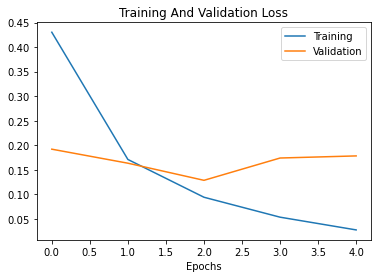

In [ ]:
cnn_base.plot_train_result(cnn_hist_base)

In [ ]:
class CNN(Model):
    
    def __init__(self):
        super().__init__()

        self.conv = tf.keras.layers.Conv2D(10,3, activation="relu", padding='same')
        self.max_pool_one = tf.keras.layers.MaxPooling2D(2,2)
        self.conv_two = tf.keras.layers.Conv2D(16,3,activation="relu",padding='same')
        self.max_pool_two = tf.keras.layers.MaxPooling2D(2,2)
        self.conv_three = tf.keras.layers.Conv2D(32,3,activation="relu", padding='same')
        self.max_pool_three = tf.keras.layers.MaxPooling2D(2,2)
        self.flat_two = tf.keras.layers.Flatten()
        self.out = tf.keras.layers.Dense(1, activation='sigmoid')
        
        
    def __call__(self, inputs, training=True):
        conv1 = self.conv(inputs)
        poll = self.max_pool_one(conv1)
        conv2 = self.conv_two(poll)
        poll2 = self.max_pool_two(conv2)
        conv3 = self.conv_three(poll2)
        poll3 = self.max_pool_three(conv3)
        flat2 = self.flat_two(poll3)

        return self.out(flat2)
    

    def analyse_result(self, origianl_data, num_sample=10) -> None:
        encoded_imgs = self.encoder(origianl_data).numpy()
        decoded_imgs = self.decoder(encoded_imgs).numpy()

        plt.figure(figsize=(20, 4))
        for i in range(num_sample):
          # display original
          ax = plt.subplot(2, num_sample, i + 1)
          plt.imshow(origianl_data[i])
          plt.title("original")
          plt.gray()
          ax.get_xaxis().set_visible(False)
          ax.get_yaxis().set_visible(False)

        for i in range(num_sample):
          # display reconstrução
          ax = plt.subplot(2, num_sample, i + 1 + num_sample)
          plt.imshow(decoded_imgs[i])
          plt.title("reconstructed")
          plt.gray()
          ax.get_xaxis().set_visible(False)
          ax.get_yaxis().set_visible(False)


    def plot_train_result(self, hist) -> None:
        plt.plot(hist.history['loss'])
        plt.plot(hist.history['val_loss'])
        plt.legend(['Training','Validation'])
        plt.title("Training And Validation Loss")
        plt.xlabel("Epochs")

In [ ]:
cnn = CNN()
cnn.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
cnn_hist = cnn.fit(train_data, epochs=5, validation_data=val_data, validation_steps=len(val_data))

  ...
    to  
  ['...']
Train for 262 steps, validate for 75 steps
Epoch 1/5
262/262 [==============================] - 102s 388ms/step - loss: 0.3248 - accuracy: 0.8631 - val_loss: 0.1585 - val_accuracy: 0.9404
Epoch 2/5
262/262 [==============================] - 101s 384ms/step - loss: 0.1821 - accuracy: 0.9348 - val_loss: 0.1341 - val_accuracy: 0.9530
Epoch 3/5
262/262 [==============================] - 100s 383ms/step - loss: 0.1597 - accuracy: 0.9422 - val_loss: 0.1432 - val_accuracy: 0.9454
Epoch 4/5
262/262 [==============================] - 100s 383ms/step - loss: 0.1306 - accuracy: 0.9524 - val_loss: 0.1150 - val_accuracy: 0.9597
Epoch 5/5
262/262 [==============================] - 131s 499ms/step - loss: 0.1018 - accuracy: 0.9638 - val_loss: 0.1646 - val_accuracy: 0.9492


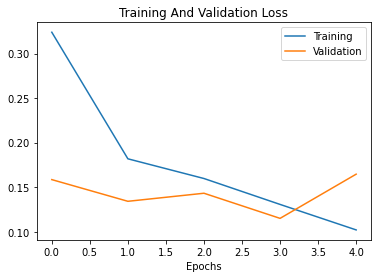

In [ ]:
cnn.plot_train_result(cnn_hist)

In [ ]:
cnn.save_weights('classification.h5')

In [ ]:
#Realizando a validação do modelo em dados de teste
validation_train_eval = cnn.evaluate(images, labels, verbose=0)
print(f'Perda: {validation_train_eval[0]}\nAcurácia: {validation_train_eval[1]}')

Perda: 0.2211754024028778
Acurácia: 0.875


In [ ]:
#Realizando a validação do modelo noconjunto de validação
validation_eval = cnn.evaluate(val_images, val_labels, verbose=0)
print(f'Perda: {validation_eval[0]}\nAcurácia: {validation_eval[1]}')

Perda: 0.05040379613637924
Acurácia: 0.96875


## Testando o modelo - Após entrega do video!!!!

Para o teste final do modelo utilizamos os dados de maça do primeiro dataset(com 3200 imgs)

In [ ]:
#Arquitetura do modelo que usaremos para o teste final
#cnn.summary()

In [ ]:
#Realizando os mesmos processos de tratamento dos dados que utilizamos 
#para treinamento do modelo para realizar a avaliação final


# test_path = 'data/test'
# test_final_datagen = ImageDataGenerator(rescale=1/255)

# test_final_data = test_final_datagen.flow_from_directory(directory=test_path,
#                                               target_size=(224, 224),
#                                               class_mode='binary',
#                                               batch_size=32)



# images, labels = test_final_data.next()
# print(f'{len(images)}, {len(labels)}')

# print(f'Tamanho do lote: {len(test_final_data)}')

In [ ]:
#Realizando a validação do modelo com o conjunto de validação
# test_eval = cnn.evaluate(images, labels, verbose=0)
# print(f'Perda: {test_eval[0]}\nAcurácia: {test_eval[1]}')

In [ ]:
cnn2 = CNN()
cnn2.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
cnn_hist2 = cnn2.fit(train_data, epochs=5, validation_data=val_data, validation_steps=len(val_data), shuffle=True)

  ...
    to  
  ['...']
Train for 262 steps, validate for 75 steps
Epoch 1/5
262/262 [==============================] - 136s 518ms/step - loss: 0.3234 - accuracy: 0.8702 - val_loss: 0.1803 - val_accuracy: 0.9324
Epoch 2/5
262/262 [==============================] - 119s 456ms/step - loss: 0.2015 - accuracy: 0.9210 - val_loss: 0.1560 - val_accuracy: 0.9471
Epoch 3/5
262/262 [==============================] - 123s 469ms/step - loss: 0.1560 - accuracy: 0.9436 - val_loss: 0.1147 - val_accuracy: 0.9559
Epoch 4/5
262/262 [==============================] - 116s 444ms/step - loss: 0.1293 - accuracy: 0.9489 - val_loss: 0.1164 - val_accuracy: 0.9572
Epoch 5/5
262/262 [==============================] - 149s 567ms/step - loss: 0.1143 - accuracy: 0.9564 - val_loss: 0.1026 - val_accuracy: 0.9643


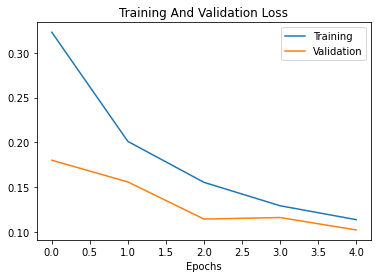

In [ ]:
cnn2.plot_train_result(cnn_hist2)

In [ ]:
#Realizando a validação do modelo em dados de teste
validation_train_eval = cnn2.evaluate(images, labels, verbose=0)
print(f'Perda: {validation_train_eval[0]}\nAcurácia: {validation_train_eval[1]}')

Perda: 0.16696614027023315
Acurácia: 0.90625


In [ ]:
cnn3 = CNN()
cnn3.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=[tf.keras.metrics.AUC()])
cnn_hist3 = cnn3.fit(train_data, epochs=5, validation_data=val_data, validation_steps=len(val_data), shuffle=True)

  ...
    to  
  ['...']
Train for 262 steps, validate for 75 steps
Epoch 1/5
262/262 [==============================] - 113s 432ms/step - loss: 0.3765 - auc: 0.9141 - val_loss: 0.2089 - val_auc: 0.9748
Epoch 2/5
262/262 [==============================] - 107s 408ms/step - loss: 0.2109 - auc: 0.9731 - val_loss: 0.1793 - val_auc: 0.9806
Epoch 3/5
262/262 [==============================] - 109s 418ms/step - loss: 0.1775 - auc: 0.9807 - val_loss: 0.1998 - val_auc: 0.9848
Epoch 4/5
262/262 [==============================] - 113s 431ms/step - loss: 0.1398 - auc: 0.9875 - val_loss: 0.1402 - val_auc: 0.9889
Epoch 5/5
262/262 [==============================] - 116s 442ms/step - loss: 0.1183 - auc: 0.9905 - val_loss: 0.1175 - val_auc: 0.9914


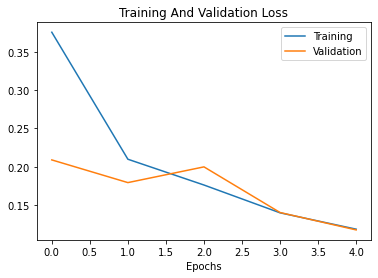

In [ ]:
cnn3.plot_train_result(cnn_hist3)

In [ ]:
#Realizando a validação do modelo em dados de teste
validation_train_eval = cnn3.evaluate(images, labels, verbose=0)
print(f'Perda: {validation_train_eval[0]}\nAcurácia: {validation_train_eval[1]}')

Perda: 0.10001499950885773
Acurácia: 0.9960317611694336


In [ ]:
###Utilizou o SGD() e piorou em relacao ao anterior

In [ ]:
cnn4 = CNN()
cnn4.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.SGD(), metrics=[tf.keras.metrics.AUC()])
cnn_hist4 = cnn4.fit(train_data, epochs=5, validation_data=val_data, validation_steps=len(val_data), shuffle=True)

  ...
    to  
  ['...']
Train for 262 steps, validate for 75 steps
Epoch 1/5
262/262 [==============================] - 108s 411ms/step - loss: 0.5725 - auc_1: 0.7708 - val_loss: 0.3727 - val_auc_1: 0.9369
Epoch 2/5
262/262 [==============================] - 109s 418ms/step - loss: 0.3462 - auc_1: 0.9261 - val_loss: 0.2845 - val_auc_1: 0.9583
Epoch 3/5
262/262 [==============================] - 106s 404ms/step - loss: 0.2929 - auc_1: 0.9469 - val_loss: 0.2903 - val_auc_1: 0.9610
Epoch 4/5
262/262 [==============================] - 106s 405ms/step - loss: 0.2695 - auc_1: 0.9552 - val_loss: 0.2376 - val_auc_1: 0.9656
Epoch 5/5
262/262 [==============================] - 107s 410ms/step - loss: 0.2567 - auc_1: 0.9595 - val_loss: 0.2198 - val_auc_1: 0.9700


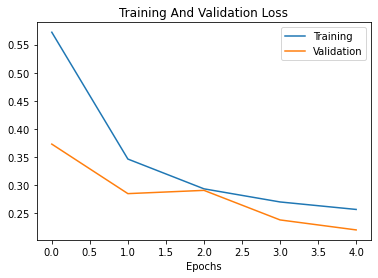

In [ ]:
cnn4.plot_train_result(cnn_hist4)

In [ ]:
#Realizando a validação do modelo em dados de teste
validation_train_eval = cnn4.evaluate(images, labels, verbose=0)
print(f'Perda: {validation_train_eval[0]}\nAcurácia: {validation_train_eval[1]}')

Perda: 0.676817774772644
Acurácia: 0.8333333134651184


In [ ]:
###Alterou o learning rate

In [ ]:
cnn5 = CNN()
cnn5.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), metrics=[tf.keras.metrics.AUC()])
cnn_hist5 = cnn5.fit(train_data, epochs=5, validation_data=val_data, validation_steps=len(val_data), shuffle=True)

  ...
    to  
  ['...']
Train for 262 steps, validate for 75 steps
Epoch 1/5
262/262 [==============================] - 108s 412ms/step - loss: 0.5374 - auc_2: 0.8049 - val_loss: 0.3105 - val_auc_2: 0.9484
Epoch 2/5
262/262 [==============================] - 109s 415ms/step - loss: 0.3095 - auc_2: 0.9422 - val_loss: 0.2577 - val_auc_2: 0.9595
Epoch 3/5
262/262 [==============================] - 107s 410ms/step - loss: 0.2805 - auc_2: 0.9523 - val_loss: 0.2411 - val_auc_2: 0.9671
Epoch 4/5
262/262 [==============================] - 108s 413ms/step - loss: 0.2649 - auc_2: 0.9574 - val_loss: 0.2480 - val_auc_2: 0.9668
Epoch 5/5
262/262 [==============================] - 108s 410ms/step - loss: 0.2497 - auc_2: 0.9620 - val_loss: 0.2167 - val_auc_2: 0.9725


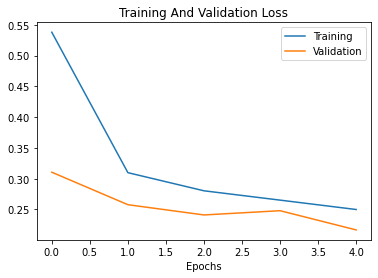

In [ ]:
cnn5.plot_train_result(cnn_hist5)

In [ ]:
#Realizando a validação do modelo em dados de teste
validation_train_eval = cnn5.evaluate(images, labels, verbose=0)
print(f'Perda: {validation_train_eval[0]}\nAcurácia: {validation_train_eval[1]}')

Perda: 0.6814671754837036
Acurácia: 0.8373016119003296


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import matplotlib.image as mpimg
import os
import random

In [ ]:
###Removeu a camada final porque a saida é categorica e nosso problema é saida binário - Demorou muito tempo (30 min)
input_shape = (224, 224, 3)
base_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer")

x = base_model(inputs, training=False)

l
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)


outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)


model_1 = keras.Model(inputs, outputs)

model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

history_1_percent = model_1.fit(train_data,
                    epochs=5,
                    validation_data=val_data,
                    validation_steps=len(val_data))

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 262 steps, validate for 75 steps
Epoch 1/5
262/262 [==============================] - 442s 2s/step - loss: 0.6782 - accuracy: 0.5789 - val_loss: 0.6555 - val_accuracy: 0.5955
Epoch 2/5
262/262 [==============================] - 441s 2s/step - loss: 0.6598 - accuracy: 0.6235 - val_loss: 0.6507 - val_accuracy: 0.6027
Epoch 3/5
262/262 [==============================] - 406s 2s/step - loss: 0.6448 - accuracy: 0.6495 - val_loss: 0.6750 - val_accuracy: 0.5708
Epoch 4/5
261/262 [============================>.] - ETA: 1s - loss: 0.6344 - accuracy: 0.6529

In [ ]:
validation_train_eval = model_1.evaluate(images, labels, verbose=0)
print(f'Perda: {validation_train_eval[0]}\nAcurácia: {validation_train_eval[1]}')

### Melhor modelo com outro conjunto de teste das 3200 (com excessão da maçã)